# Задание 2. Анализ временных последовательностей нейронными сетями.

**Цель работы** – получить навыки создания нейронных сетей для анализа сигналов с помощью моделей рекуррентных сетей и ячеек LSTM (GRU).

**Задачи** – Построить три нейросетевые модели:
1. Регрессор встречного распространения
2. Регрессор, ячейку LSTM (или GRU) в скрытом слое
3. Регрессор, содержащий две последовательные ячейки LSTM (или GRU)


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Описание наборов данных

In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Kaliningrad_weather_19102020_15102011.csv",sep=';', encoding='iso-8859-1')
data.head()


,LocalTime,T,Po,P,Pa,U,DD
0,19.10.2020 11:00,8.0,761.2,762.5,NaN,83.0,Âåòåð
1,19.10.2020 08:00,5.3,760.0,761.3,NaN,90.0,Âåòåð
2,19.10.2020 05:00,3.1,759.2,760.6,NaN,94.0,Âåòåð
3,19.10.2020 02:00,2.9,758.2,759.6,NaN,90.0,Âåòåð
4,18.10.2020 23:00,3.0,757.2,758.5,NaN,91.0,Âåòåð


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26269 entries, 0 to 26268
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LocalTime  26269 non-null  object 
 1   T          26253 non-null  float64
 2   Po         26237 non-null  float64
 3   P          26221 non-null  float64
 4   Pa         21831 non-null  float64
 5   U          26233 non-null  float64
 6   DD         25864 non-null  object 
dtypes: float64(5), object(2)
memory usage: 1.4+ MB


#Признаки, которые были использованы для анализа

In [ ]:
data = data[['LocalTime', 'T']]

In [ ]:
data.isna().sum()

,0
LocalTime,0
T,16


In [ ]:
data = data.dropna()

In [ ]:
data.isna().sum()

,0
LocalTime,0
T,0


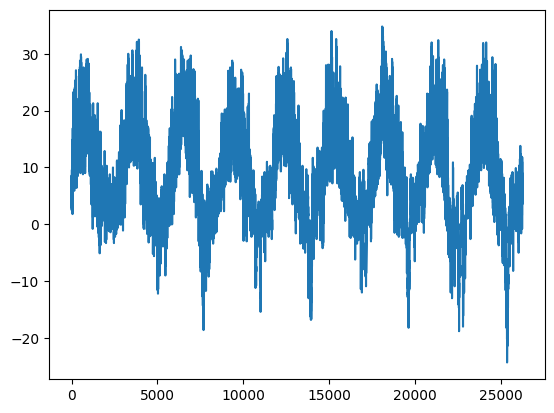

In [ ]:
plt.plot(range(1, len(data['T'].values) +1), data['T'].values)

Эта строка использует библиотеку matplotlib.pyplot (импортированную как plt) для создания простого линейного графика. Вот что происходит:

1. `plt.plot()`: Это функция, которая создает график. Она принимает два основных аргумента: значения по оси x и значения по оси y.

2. `range(1, len(data['T'].values) + 1)`: Это генерирует последовательность чисел, которые будут использоваться в качестве значений по оси x для графика.

  - `data['T'].values` извлекает значения из столбца 'T' (вероятно, температура) из DataFrame data в виде массива NumPy.
  - `len(data['T'].values)` получает общее количество значений температуры.
  - `range(1, len(data['T'].values) + 1)` создает последовательность чисел от 1 до общего количества значений температуры. Это делается для того, чтобы обеспечить индекс для оси x, начиная с 1 вместо 0.

3. `data['T'].values`: Это второй аргумент для `plt.plot()` и предоставляет значения по оси y для графика. Это просто значения температуры, извлеченные ранее.

In [ ]:
# Extract and normalize the target column
min_max_scaler = MinMaxScaler()
data = data['T'].values
data = min_max_scaler.fit_transform(data.reshape(-1,1))

1. `min_max_scaler = MinMaxScaler()`: Эта строка создает экземпляр класса MinMaxScaler из модуля sklearn.preprocessing. Этот инструмент будет использоваться для нормализации данных.

2. `data = data['T'].values`: Эта строка извлекает значения из столбца 'T' (который, представляет температуру) из DataFrame data и присваивает их переменной data. Атрибут .values преобразует столбец в массив NumPy.

3. `data = min_max_scaler.fit_transform(data.reshape(-1,1))`: Это ядро процесса нормализации. Разберем его подробнее:

  - `data.reshape(-1,1)`: Эта часть изменяет форму массива data в формат, подходящий для MinMaxScaler. -1 в функции reshape указывает, что NumPy должен автоматически рассчитать количество строк на основе размера массива и указанного количества столбцов (которое равно 1 в данном случае). По сути, он преобразует данные из одномерного массива в двумерный массив с одним столбцом. Это необходимо, потому что MinMaxScaler ожидает на входе двумерный массив.
  - `min_max_scaler.fit_transform(...)`: Эта часть выполняет две задачи:
    - `fit`: Инструмент масштабирования изучает минимальное и максимальное значения из массива data. Он вычисляет эту статистику, чтобы понять диапазон данных.
    - `transform`: Он применяет изученное масштабирование к самим data, преобразовывая значения в диапазон от 0 до 1 (по умолчанию). Это делается путем вычитания минимального значения и деления на диапазон (максимум - минимум) для каждого значения в данных.

In [ ]:
data.shape

(26253, 1)

In [ ]:
# Flatten the data shape
data = data.flatten()
print(data.shape)

(26253,)


Основная цель здесь — преобразовать переменную data, которая, является многомерным массивом (например, матрицей), в одномерный массив (например, простой список чисел). Этот процесс называется "выравниванием" или "сплющиванием".

In [ ]:
window = 15

# Calculate the number of samples for training, validation, and test sets
n_samples = data.shape[0] - window
n_train_samples = round(.7 * n_samples)
n_val_samples = round(.15 * n_samples)
n_test_samples= n_samples - n_train_samples - n_val_samples

print('Train = ', n_train_samples,
      'Validation = ', n_val_samples,
      'Test = ', n_test_samples)

Train =  18367 Validation =  3936 Test =  3935


1. `window = 15`:

  - Эта строка определяет переменную с именем window и устанавливает ее значение равным 15.
  - window, представляет собой период ретроспективного анализа или длину последовательности. В анализе временных рядов это означает, что модель будет использовать предыдущие 15 точек данных (например, показания температуры) для прогнозирования следующей точки данных.

2. `n_samples = data.shape[0] - window`:

  - `data.shape[0]` возвращает общее количество точек данных в вашем наборе данных.
  - Мы вычитаем размер window, потому что нам нужно учесть период ретроспективного анализа. У последних window точек данных не будет достаточно предшествующих данных, чтобы сформировать полную входную последовательность.
  - `n_samples` теперь содержит общее количество используемых выборок для обучения, валидации и тестирования.

3. `n_train_samples = round(.7 * n_samples)`:

  - Эта строка вычисляет количество выборок для обучающего набора.
  - Она берет 70% (0.7) от общего количества используемых выборок (`n_samples`) и округляет до ближайшего целого числа.
  - Обучающий набор - это самая большая часть данных, которая используется для обучения модели распознаванию закономерностей в данных.

4. `n_val_samples = round(.15 * n_samples)`:

  - Эта строка вычисляет количество выборок для валидационного набора.
  - Она берет 15% (0.15) от общего количества используемых выборок и округляет до ближайшего целого числа.
  - Валидационный набор используется для оценки производительности модели во время обучения и для тонкой настройки параметров модели. Он помогает предотвратить переобучение, которое возникает, когда модель хорошо работает на обучающих данных, но плохо на невидимых данных.

5. `n_test_samples= n_samples - n_train_samples - n_val_samples`:

  - Эта строка вычисляет количество выборок для тестового набора.
  - Она берет оставшиеся выборки после выделения для обучающего и валидационного наборов. В этом случае это будет около 15% (100% - 70% - 15%).
  - Тестовый набор откладывается до самого конца и используется для получения окончательной, непредвзятой оценки производительности модели на невидимых данных.

6. `print(...)`:
  - Эта строка просто выводит вычисленные размеры обучающего, валидационного и тестового наборов в консоль, предоставляя вам обзор разделения данных.

In [ ]:
# Function to create input-output pairs or a given set
def create_pais(start_index, num_samples):
  X= [data[start_index + i : start_index + i + window] for i in range(num_samples)]
  y = [data[start_index + i + window] for i in range(num_samples)]
  return np.array(X), np.array(y)

1. `def create_pais(start_index, num_samples)`:

  - Эта строка определяет функцию с именем `create_pais`, которая принимает два аргумента:
    - `start_index`: Индекс в массиве data, с которого начинается создание пар.
    - `num_samples`: Общее количество пар входных-выходных данных, которые нужно создать.

2. `X = [data[start_index + i : start_index + i + window] for i in range(num_samples)]`:

  - Эта строка создает входные данные (X).
  - Она использует генератор списков для создания списка подпоследовательностей из массива data.
  - Для каждого i в диапазоне num_samples он извлекает фрагмент данных, начинающийся с start_index + i и заканчивающийся на start_index + i + window. Этот фрагмент становится одной входной последовательностью.
  - Напомним, что window был определен ранее и представляет собой период ретроспективного анализа или количество предыдущих временных шагов, которые необходимо учитывать для прогнозирования следующего значения.
  - Следовательно, каждый элемент в X представляет собой последовательность длиной window, представляющую историческое окно данных.

3. `y = [data[start_index + i + window] for i in range(num_samples)]`:

  - Эта строка создает выходные данные (y).
  - Она также использует генератор списков для создания списка целевых значений.
  - Для каждого i он берет точку данных, которая непосредственно следует за входной последовательностью в X. Это значение, которое модель будет обучена предсказывать.

4. `return np.array(X), np.array(y)`:

  - Эта строка преобразует списки X and y в массивы NumPy, которые более эффективны для численных вычислений.
  - Наконец, она возвращает эти два массива в виде кортежа, представляющего пары входных-выходных данных, готовые к использованию для обучения модели.

In [ ]:
# Create training, validation , and test sets

X_train, y_train = create_pais(0, n_train_samples)
X_val, y_val = create_pais(n_train_samples, n_val_samples)
X_test, y_test = create_pais(n_train_samples + n_val_samples, n_test_samples)

1. `X_train, y_train = create_pais(0, n_train_samples)`:

  - Эта строка создает обучающий набор данных.
  - Она вызывает функцию create_pais, которую мы обсудим чуть позже.
  - В качестве start_index передается 0, что означает начало с самого начала данных.
  - Передается n_train_samples, чтобы указать количество обучающих выборок для создания.
  - Функция create_pais возвращает два массива:
    - X_train: Будет содержать входные признаки для обучения (вероятно, последовательность прошлых значений температуры).
    - y_train: Будет содержать соответствующие целевые значения для обучения (вероятно, значение температуры, которое нужно предсказать).

2. `X_val, y_val = create_pais(n_train_samples, n_val_samples)`:

  - Эта строка создает валидационный набор данных.
  - Она снова вызывает create_pais.
  - На этот раз в качестве start_index передается n_train_samples. Это гарантирует, что валидационный набор начинается там, где заканчивается обучающий набор, избегая перекрытия.
  - Передается n_val_samples, чтобы указать количество валидационных выборок.
  - Аналогично предыдущему, получаем X_val (входные признаки для валидации) и y_val (целевые значения для валидации).

3. `X_test, y_test = create_pais(n_train_samples + n_val_samples, n_test_samples)`:

  - Эта строка создает тестовый набор данных.
  - Она следует той же логике, что и предыдущие строки, вызывая create_pais.
  - start_index устанавливается равным n_train_samples + - n_val_samples, гарантируя, что тестовый набор начинается после обучающего и валидационного наборов.
  - Передается n_test_samples, чтобы указать количество тестовых выборок.
  - Получаем X_test (входные признаки для тестирования) и y_test (целевые значения для тестирования).

In [ ]:
# Reshape the data

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test= np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

1. `np.reshape`: Эта функция является основой операции. Она принимает существующий массив NumPy и возвращает новый массив с теми же данными, но организованными в другую форму.

2. `(X_train.shape[0], 1, X_train.shape[1])`: Эта часть указывает желаемую новую форму для данных. Давайте разберем ее:
  - `X_train.shape[0]`: Это относится к исходному количеству образцов или строк в X_train. Новая форма сохранит это измерение.
  - 1: Это вводит новое измерение размера 1. Это часто требуется для определенных типов моделей машинного обучения, в частности рекуррентных нейронных сетей (RNN), таких как LSTM, которые ожидают, что входные данные будут иметь определенную трехмерную структуру (образцы, временные шаги, признаки).
  - `X_train.shape[1]`: Это относится к исходному количеству признаков или столбцов в X_train. Это измерение также сохраняется в новой форме.

3. Применение к `X_val` и `X_test`: Та же логика изменения формы применяется к данным валидации (X_val) и тестовым данным (X_test), чтобы обеспечить согласованность и совместимость с требованиями модели к входным данным.

# Параметры архитектур и обучения нейронных сетей, использованные для обучения

## Регрессор (RNN)

In [ ]:
# Build the RNN model

rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1. `rnn_model = tf.keras.Sequential(...)`:

  - Эта строка создает модель RNN с использованием API Sequential из Keras. Sequential означает, что модель будет обрабатывать слои один за другим в линейной последовательности.
  - Вся структура модели определяется внутри квадратных скобок [...].

2. `tf.keras.layers.SimpleRNN(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))`:

  - Это ядро модели RNN – слой SimpleRNN.
  - 10: Это указывает количество "единиц" или "нейронов" внутри слоя RNN. Эти единицы отвечают за изучение закономерностей в последовательных данных.
  - activation='relu': Функция 'relu' (Rectified Linear Unit) используется для введения нелинейности в модель, позволяя ей изучать более сложные взаимосвязи в данных.
  - input_shape=(X_train.shape[1], X_train.shape[2]): Это определяет форму входных данных, которую ожидает слой RNN. Она берется из размеров ваших обучающих данных (X_train). Форма ввода, вероятно, (1, window), что означает, что модель получает один временной шаг за раз с window признаками (15 исторических точек данных в данном случае).

3. `Dropout(0.2)`:

  - Это метод регуляризации для предотвращения переобучения. Во время обучения он случайным образом "выбрасывает" (игнорирует) 20% нейронов в предыдущем слое. Это заставляет модель изучать более надежные признаки и лучше обобщать на невидимых данных.

4. `tf.keras.layers.Dense(1, activation='linear')`:

  - Это полносвязный (Dense) слой, который производит окончательный вывод модели.
  - 1: Он имеет один нейрон, который соответствует одному значению, которое предсказывает модель (например, температура на следующем временном шаге).
  - activation='linear': Используется линейная функция активации, что означает, что выход представляет собой простую линейную комбинацию входных данных из предыдущего слоя. Это характерно для задач регрессии (предсказания непрерывных значений).

In [ ]:
# Complie the RNN Model

rnn_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae'])

1. `rnn_model.compile(...)`: Эта строка — основная команда для запуска процесса компиляции для `rnn_model` (которая была определена ранее в коде). Компиляция — это как дать модели инструкции о том, как учиться.

2. `loss='mse'`:
  - loss — это важный аргумент, который определяет функцию потерь. Эта функция вычисляет разницу между предсказаниями модели и фактическими целевыми значениями.
  - `'mse'` означает Среднеквадратичная ошибка (Mean Squared Error), распространенную функцию потерь для задач регрессии. Она вычисляет среднее квадратов разностей между предсказанными и фактическими значениями. Цель модели во время обучения — минимизировать эту потерю.

3. `optimizer='adam'`:

  - `optimizer` определяет алгоритм оптимизации, используемый для обновления внутренних весов модели во время обучения. Эти веса — это то, что модель изучает, чтобы делать более точные предсказания.
  - `'adam'` относится к оптимизатору Adam, популярному и эффективному алгоритму для обучения нейронных сетей. Он адаптивно корректирует скорость обучения для каждого параметра, что приводит к более быстрой и стабильной сходимости.

4. `metrics=['mae']`:

  - `metrics` указывает метрики оценки, используемые для мониторинга производительности модели во время обучения и тестирования. В то время как функция потерь направляет процесс оптимизации, метрики обеспечивают более понятную для человека оценку точности модели.
  - `'mae'` означает Средняя абсолютная ошибка (Mean Absolute Error), еще одну распространенную метрику для регрессии. Она вычисляет среднее абсолютных разностей между предсказанными и фактическими значениями. Это дает представление о средней ошибке прогнозирования в тех же единицах, что и целевая переменная.

In [ ]:
# Останавливаем обучение, если валидационная точность не улучшилась в течение 10 эпох
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=10,
    mode='max',
    verbose=1
)

# Сохраняем веса модели, если валидационная точность улучшилась
checkpoint = ModelCheckpoint(
    'Kaliningrad_weather-{epoch:02d}-{val_mae:.3f}.keras',
    monitor='val_mae',
    verbose=1,
    mode='max',
    save_best_only=True
)

# Список колбеков, который будет передан в модель
callbacks_list = [early_stop, checkpoint]


Этот код определяет два важных "обратных вызова" – `early_stop` и `checkpoint` – а затем объединяет их в список под названием `callbacks_list`. Эти обратные вызовы – это функции, которые будут выполняться во время обучения нейронной сети для мониторинга и управления ее прогрессом.
<br>
<br>
**EarlyStopping**

- Цель: Этот обратный вызов предназначен для досрочного прекращения процесса обучения, если производительность модели на данных проверки перестает улучшаться. Это помогает предотвратить переобучение, когда модель становится слишком специализированной для обучающих данных и плохо обобщается на новые, невидимые данные.
- `monitor='val_mae'`: Это говорит EarlyStopping отслеживать "среднюю абсолютную ошибку" (mae) на наборе данных проверки (val_mae). Набор данных проверки – это часть ваших данных, на которых модель не обучается напрямую, используемая для оценки того, насколько хорошо она обобщается.
- `patience=10'`: Это означает, что обучение будет продолжаться до 10 эпох (проходов через весь обучающий набор данных), даже если val_mae не улучшается. Это дает модели некоторую свободу действий, чтобы потенциально преодолеть временное плато в производительности.
- `mode='max'`: Так как мы отслеживаем val_mae, и чем ниже mae, тем лучше, mode должен быть 'min'.
- `verbose=1'`: Этот параметр гарантирует, что вы увидите сообщения, выводимые на консоль, когда EarlyStopping предпринимает действия (т.е. когда он останавливает обучение). <br><br>

**ModelCheckpoint**

- Цель: Этот обратный вызов сохраняет веса модели (выученные параметры) во время обучения. Это позволяет вам загрузить версию модели с наилучшей производительностью позже, даже если процесс обучения прерван или если модель начинает переобучаться.
- `'Kaliningrad_weather-{epoch:02d}-{val_mae:.3f}.keras'`: Это определяет шаблон имени файла для сохраненных весов модели.
  - `Kaliningrad_weather` – это префикс для имени.
  - `{epoch:02d}` вставляет текущий номер эпохи (отформатированный с ведущими нулями).
  - `{val_mae:.3f}` вставляет mae проверки (отформатированный до трех десятичных знаков).
  - `.keras` – это расширение файла.
- `monitor='val_mae'`: Подобно EarlyStopping, это говорит ModelCheckpoint отслеживать mae проверки.
- `verbose=1'`: Выводит сообщения при сохранении модели.
- `mode='max'`: Должен быть 'min', так как мы хотим сохранить модель, когда val_mae ниже, что указывает на лучшую производительность.
- `save_best_only=True'`: Это очень важный параметр. Он гарантирует, что сохраняется только модель с лучшим val_mae, наблюдаемым до сих пор. Это позволяет избежать сохранения потенциально хуже работающих моделей из более поздних эпох.<br><br>

**callback_list**

- Цель: Это просто объединяет два обратных вызова в список. Этот список будет передан методу fit модели во время обучения, что позволит этим обратным вызовам быть активными и выполнять свою работу.

In [ ]:
# Train the RNN Model

rnn_history = rnn_model.fit(X_train, y_train, batch_size = 10,
                            validation_data = (X_val, y_val),
                            callbacks = callbacks_list, epochs = 100)

Epoch 1/100
1830/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - mae: 0.1110
Epoch 1: val_mae improved from -inf to 0.05011, saving model to Kaliningrad_weather-01-0.050.keras
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0224 - mae: 0.1109 - val_loss: 0.0044 - val_mae: 0.0501
Epoch 2/100
1816/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0569
Epoch 2: val_mae did not improve from 0.05011
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0058 - mae: 0.0569 - val_loss: 0.0035 - val_mae: 0.0408
Epoch 3/100
1831/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - mae: 0.0495
Epoch 3: val_mae did not improve from 0.05011
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0045 - mae: 0.0495 - val_loss: 0.0033 - val_mae: 0.0394
Epoch 4/100
1818/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mae: 0.0466
Epoch 4: val_mae did not improve from 0.05011
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0040 - mae: 0.0466 - val_loss: 0.0018 - val_mae

### MSE, MAE & R2

In [ ]:
# Get R2, MSE & MAE scores

y_pred = rnn_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R-squared (R^2): {r2:.2f}')

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.00
MAE: 0.03
R-squared (R^2): 0.94


Этот фрагмент кода отвечает за оценку производительности обученной RNN модели (rnn_model) с использованием трех распространенных метрик регрессии: Среднеквадратичной ошибки (MSE), Средней абсолютной ошибки (MAE) и коэффициента детерминации (R^2).

1. y_pred = rnn_model.predict(X_test):

  - Эта строка использует обученную rnn_model для создания прогнозов на тестовых данных (X_test).
  - Прогнозы сохраняются в переменной y_pred.

2. mse = mean_squared_error(y_test, y_pred):
  - Эта строка вычисляет среднеквадратичную ошибку (MSE) между фактическими значениями (y_test) и предсказанными значениями (y_pred).
  - MSE является мерой средней квадратичной разницы между предсказанными и фактическими значениями. Более низкие значения указывают на лучшую производительность модели.

3. mae = mean_absolute_error(y_test, y_pred):
  - Эта строка вычисляет среднюю абсолютную ошибку (MAE) между фактическими значениями (y_test) и предсказанными значениями (y_pred).
  - MAE является мерой средней абсолютной разницы между предсказанными и фактическими значениями. Ее легче интерпретировать, чем MSE, поскольку она выражается в тех же единицах, что и целевая переменная. Более низкие значения указывают на лучшую производительность модели.

4. r2 = r2_score(y_test, y_pred):

  - Эта строка вычисляет коэффициент детерминации (R^2) между фактическими значениями (y_test) и предсказанными значениями (y_pred).
  - R^2 - это статистическая мера, которая представляет долю дисперсии целевой переменной, которая объясняется моделью. Он варьируется от 0 до 1, где более высокие значения указывают на лучшую подгонку модели к данным.

#Oценки моделей на тестовых выборках в виде таблиц/ диаграмм, отображающих метрики качества

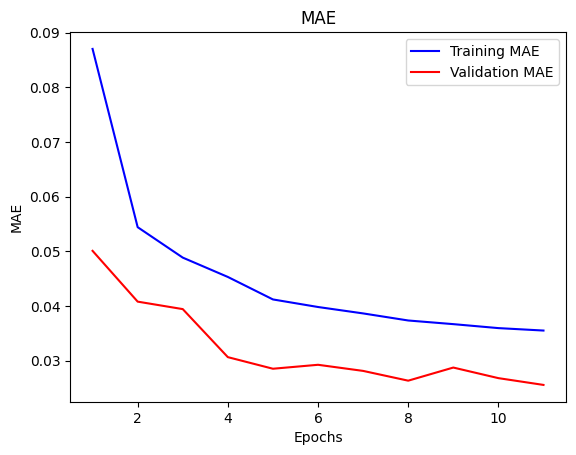

In [ ]:
# Visualise the MAE
mae = rnn_history.history['mae']
val_mae = rnn_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('MAE')
plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

1. `mae = rnn_history.history['mae']`:

  - Эта строка извлекает значения MAE на обучающих данных из объекта rnn_history. rnn_history - это объект, который возвращается при обучении модели RNN с помощью `rnn_model.fit()`. Он хранит информацию о процессе обучения, включая MAE для каждой эпохи.
  - Часть `history['mae']` обращается именно к значениям MAE на обучающих данных и присваивает их переменной mae.

2. `val_mae = rnn_history.history['val_mae']`:

  - Эта строка аналогична предыдущей, но извлекает значения MAE на проверочных данных из `rnn_history`.
  - MAE на проверочных данных рассчитывается на отдельном наборе данных (проверочный набор), на котором модель не обучалась напрямую. Это помогает оценить, насколько хорошо модель обобщается на невидимые данные.

3. `epochs = range(1, len(mae) + 1)`:

  - Эта строка создает последовательность чисел, представляющих эпохи процесса обучения.
  - `len(mae)` дает общее количество эпох.
  - `range(1, len(mae) + 1)` создает последовательность, начинающуюся с 1 и доходящую до общего количества эпох. Эта последовательность будет использоваться в качестве значений оси x на графике.

### Predicting

In [ ]:
# Predicting using test sets

y_pred = rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE =  1.59  degrees
R2-score =  0.941


1. `y_pred = rnn_model.predict(X_test)`:

  - Эта строка использует обученную rnn_model для прогнозирования целевой переменной (вероятно, температуры) для тестового набора (X_test).
  - Прогнозы сохраняются в переменной y_pred. Эти прогнозы все еще находятся в масштабированном формате (от 0 до 1), потому что модель была обучена на масштабированных данных.

2. `y_pred_inv = min_max_scaler.inverse_transform(y_pred)`:

  - Эта строка отменяет масштабирование, примененное к прогнозам (`y_pred`), чтобы вернуть их к исходным единицам измерения (например, градусам Цельсия).
  - Для выполнения обратного преобразования используется объект `min_max_scaler` (который, использовался ранее для масштабирования данных).
  - Результаты, прогнозы в исходном масштабе, сохраняются в `y_pred_inv`.

3. `y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))`:

  - Подобно предыдущей строке, эта строка отменяет масштабирование, примененное к фактическим целевым значениям (`y_test`).
  - Перед применением обратного преобразования y_test изменяется с помощью `reshape(-1, 1)`. Это делается для того, чтобы убедиться, что он имеет правильную форму, ожидаемую функцией `inverse_transform` (двумерный массив с одним столбцом).
  - Результаты, фактические целевые значения в исходном масштабе, сохраняются в `y_test_inv`.

4. `print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')`:

  - Эта строка вычисляет и выводит среднюю абсолютную ошибку (MAE) между фактическими значениями (`y_test_inv`) и прогнозируемыми значениями (y_pred_inv).
  - `mean_absolute_error` - это функция из scikit-learn (`sklearn.metrics`), которая вычисляет MAE.
  - `round(..., 3)` округляет значение MAE до трех десятичных знаков для лучшей читаемости.
  - `' degrees'` добавляется к выводу, чтобы указать единицу измерения ошибки (вероятно, градусы Цельсия).

5. `print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))`:

  - Эта строка вычисляет и выводит коэффициент детерминации (R^2) между фактическими значениями (`y_test_inv`) и прогнозируемыми значениями (`y_pred_inv`).
  - r2_score - это функция из scikit-learn (`sklearn.metrics`), которая вычисляет коэффициент детерминации.
  - `round(..., 3)` округляет коэффициент детерминации до трех десятичных знаков.

# Графики обучения для архитектур нейронных сетей

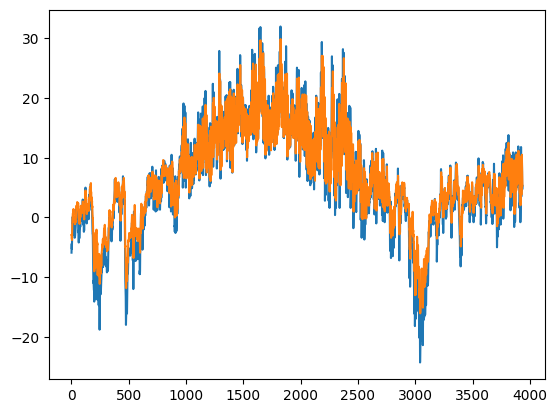

In [ ]:
# Visualise prediction
plt.plot(range(1, len(y_test_inv)+1), y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1), y_pred_inv)

## Регрессор (ячейку LSTM)

In [ ]:
# Build the LSTM model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1. `lstm_model = tf.keras.Sequential(...)`:

  - Эта строка создает модель LSTM, используя API `Sequential` в Keras. Это означает, что модель будет обрабатывать слои один за другим в линейной последовательности.
  - Вся структура модели определяется внутри квадратных скобок [...].

2. `tf.keras.layers.LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))`:

  - Это ядро модели LSTM - сам слой LSTM.
  - 10: Это указывает количество "единиц" или "нейронов" внутри слоя LSTM. Эти единицы отвечают за изучение закономерностей в последовательных данных.
  - `activation='relu'`: Функция `relu` (Rectified Linear Unit - Выпрямленный линейный блок) используется для введения нелинейности в модель, позволяя ей изучать более сложные взаимосвязи в данных.
  - `input_shape=(X_train.shape[1], X_train.shape[2])`: Это определяет форму входных данных, которую ожидает слой LSTM. Она берется из размеров ваших обучающих данных (`X_train`). Эта форма ввода означает, что модель получает один временной шаг за раз с определенным количеством признаков (определяется `X_train.shape[2]`, который, представляет исторические точки данных).

3. `Dropout(0.2)`:

  - Это метод регуляризации для предотвращения переобучения. Во время обучения он случайным образом "выбрасывает" (игнорирует) 20% нейронов в предыдущем слое. Это заставляет модель изучать более надежные признаки и лучше обобщать на невидимые данные.

4. `tf.keras.layers.Dense(1, activation='linear')`:

  - Это полносвязный (Dense) слой, который производит окончательный вывод модели.
  - 1: Он имеет один нейрон, который соответствует одному значению, которое предсказывает модель (например, температура на следующем временном шаге).
  - `activation='linear'`: Используется линейная функция активации, что означает, что выход представляет собой простую линейную комбинацию входных данных из предыдущего слоя. Это характерно для задач регрессии (предсказания непрерывных значений).

In [ ]:
# Compile the LSTM model

lstm_model.compile(loss='mse',
                   optimizer='adam',
                   metrics=['mae'])

1. `lstm_model.compile(...)`: Эта строка инициирует процесс компиляции для `lstm_model` (которая была определена ранее в вашем коде). Компиляция - это как дать модели инструкции о том, как учиться.

2. `loss='mse'`:

  - `loss` - это важный аргумент, который определяет функцию потерь. Эта функция вычисляет разницу между предсказаниями модели и фактическими целевыми значениями.
  - `'mse'` означает Среднеквадратичную ошибку (Mean Squared Error), распространенную функцию потерь для задач регрессии. Она вычисляет среднее квадратов разностей между предсказанными и фактическими значениями. Цель модели во время обучения — минимизировать эту потерю.

3. `optimizer='adam'`:

  - `optimizer` определяет алгоритм оптимизации, используемый для обновления внутренних весов модели во время обучения. Эти веса — это то, что модель изучает, чтобы делать более точные предсказания.
  - `'adam'` относится к оптимизатору Adam, популярному и эффективному алгоритму для обучения нейронных сетей. Он адаптивно корректирует скорость обучения для каждого параметра, что приводит к более быстрой и стабильной сходимости.

4. `metrics=['mae']`:

  - `metrics` указывает метрики оценки, используемые для мониторинга производительности модели во время обучения и тестирования. В то время как функция потерь направляет процесс оптимизации, метрики обеспечивают более понятную для человека оценку точности модели.
  - `'mae'` означает Среднюю абсолютную ошибку (Mean Absolute Error), еще одну распространенную метрику для регрессии. Она вычисляет среднее абсолютных разностей между предсказанными и фактическими значениями. Это дает представление о средней ошибке прогнозирования в тех же единицах, что и целевая переменная.

In [ ]:
# Останавливаем обучение, если валидационная точность не улучшилась в течение 10 эпох
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=10,
    mode='max',
    verbose=1
)

# Сохраняем веса модели, если валидационная точность улучшилась
checkpoint = ModelCheckpoint(
    'Kaliningrad_weather-{epoch:02d}-{val_mae:.3f}.keras',
    monitor='val_mae',
    verbose=1,
    mode='max',
    save_best_only=True
)

# Список колбеков, который будет передан в модель
callbacks_list = [early_stop, checkpoint]


**EarlyStopping (Ранняя остановка)**

- Цель: Этот обратный вызов предназначен для досрочного прекращения процесса обучения, если производительность модели на данных проверки перестает улучшаться. Это помогает предотвратить переобучение, когда модель становится слишком специализированной для обучающих данных и плохо обобщается на новые, невидимые данные.
- `monitor='val_mae'`: Это говорит EarlyStopping отслеживать "среднюю абсолютную ошибку" (mae) на наборе данных проверки (`val_mae`). Набор данных проверки – это часть ваших данных, на которых модель не обучается напрямую, используемая для оценки того, насколько хорошо она обобщается.
- `patience=10'`: Это означает, что обучение будет продолжаться до 10 эпох (проходов через весь обучающий набор данных), даже если val_mae не улучшается. Это дает модели некоторую свободу действий, чтобы потенциально преодолеть временное плато в производительности.
- `mode='max'`: Так как мы отслеживаем `val_mae`, и чем ниже mae, тем лучше, mode должен быть 'min'.
- `verbose=1'`: Этот параметр гарантирует, что вы увидите сообщения, выводимые на консоль, когда EarlyStopping предпринимает действия (т.е. когда он останавливает обучение). <br> <br>

**ModelCheckpoint (Контрольная точка модели)**

- Цель: Этот обратный вызов сохраняет веса модели (выученные параметры) во время обучения. Это позволяет вам загрузить версию модели с наилучшей производительностью позже, даже если процесс обучения прерван или если модель начинает переобучаться.
- `'Kaliningrad_weather-{epoch:02d}-{val_mae:.3f}.keras'`: Это определяет шаблон имени файла для сохраненных весов модели.
  - Kaliningrad_weather – это префикс для имени.
  - {epoch:02d} вставляет текущий номер эпохи (отформатированный с ведущими нулями).
  - {val_mae:.3f} вставляет mae проверки (отформатированный до трех десятичных знаков).
  - .keras – это расширение файла.
- `monitor='val_mae'`: Подобно EarlyStopping, это говорит ModelCheckpoint отслеживать mae проверки.
- `verbose=1'`: Выводит сообщения при сохранении модели.
- `mode='max'`: Должен быть 'min', так как мы хотим сохранить модель, когда val_mae ниже, что указывает на лучшую производительность.
- `save_best_only=True'`: Это очень важный параметр. Он гарантирует, что сохраняется только модель с лучшим val_mae, наблюдаемым до сих пор. Это позволяет избежать сохранения потенциально хуже работающих моделей из более поздних эпох. <br><br>

**callback_list (Список обратных вызовов)**

- Цель: Это просто объединяет два обратных вызова в список. Этот список будет передан методу fit модели во время обучения, что позволит этим обратным вызовам быть активными и выполнять свою работу.

In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, batch_size = 10,
                            validation_data = (X_val, y_val),
                            callbacks = callbacks_list, epochs = 100)

Epoch 1/100
1813/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0535 - mae: 0.1621
Epoch 1: val_mae improved from -inf to 0.06235, saving model to Kaliningrad_weather-01-0.062.keras
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0531 - mae: 0.1614 - val_loss: 0.0063 - val_mae: 0.0624
Epoch 2/100
1829/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 - mae: 0.0664
Epoch 2: val_mae did not improve from 0.06235
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0079 - mae: 0.0664 - val_loss: 0.0021 - val_mae: 0.0341
Epoch 3/100
1822/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - mae: 0.0442
Epoch 3: val_mae did not improve from 0.06235
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0037 - mae: 0.0442 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 4/100
1834/1837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mae: 0.0414
Epoch 4: val_mae did not improve from 0.06235
1837/1837 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0033 - mae: 0.0414 - val_loss: 0.0012 - val_m

### MSE, MAE & R2

In [ ]:
# Get R2, MSE, & MAE scores
y_pred = lstm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared (R^2): {r2:.2f}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MSE: 0.00
MAE: 0.03
R-squared (R^2): 0.94


1. `y_pred = lstm_model.predict(X_test)`:

  - Эта строка использует обученную `lstm_model` для создания прогнозов на тестовых данных (`X_test`).
  - Прогнозы сохраняются в переменной `y_pred`.

2. `mse = mean_squared_error(y_test, y_pred)`:
  - Эта строка вычисляет среднеквадратичную ошибку (MSE) между фактическими значениями (`y_test`) и предсказанными значениями (`y_pred`).
  - MSE является мерой средней квадратичной разницы между предсказанными и фактическими значениями. Чем ниже значение, тем лучше производительность модели.

3. `mae = mean_absolute_error(y_test, y_pred)`:
  - Эта строка вычисляет среднюю абсолютную ошибку (MAE) между фактическими значениями (`y_test`) и предсказанными значениями (`y_pred`).
  - MAE является мерой средней абсолютной разницы между предсказанными и фактическими значениями. Ее легче интерпретировать, чем MSE, поскольку она выражается в тех же единицах, что и целевая переменная. Чем ниже значение, тем лучше производительность модели.

4. `r2 = r2_score(y_test, y_pred)`:
  - Эта строка вычисляет коэффициент детерминации (R^2) между фактическими значениями (`y_test`) и предсказанными значениями (`y_pred`).
  - R^2 - это статистическая мера, которая представляет долю дисперсии целевой переменной, которая объясняется моделью. Он варьируется от 0 до 1, где более высокие значения указывают на лучшую подгонку модели к данным.

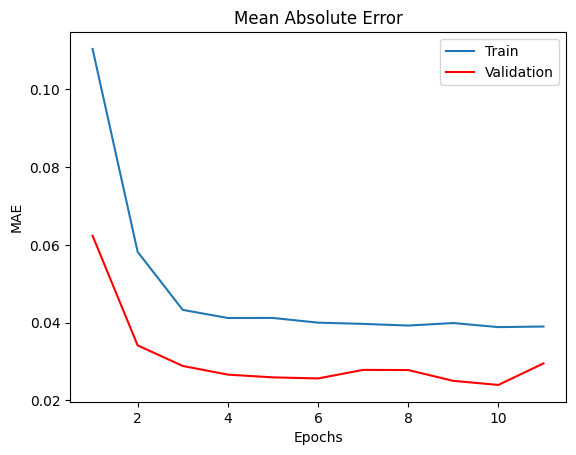

In [ ]:
# Visualize the mean absolute error
mae = lstm_history.history['mae']
val_mae = lstm_history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Mean Absolute Error')
plt.plot(epochs,mae,label='Train')
plt.plot(epochs,val_mae,color='red',label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Predicting

In [ ]:
# Predict using test sets

y_pred = lstm_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE =  1.788  degrees
R2-score =  0.937


1. `y_pred = lstm_model.predict(X_test)`:

  - Эта строка использует обученную модель `lstm_model` для прогнозирования целевой переменной (вероятно, температуры) для тестового набора данных (`X_test`).
  - Прогнозы сохраняются в переменной `y_pred`. Эти прогнозы, все еще находятся в масштабированном формате (от 0 до 1), потому что модель была обучена на масштабированных данных.

2. `y_pred_inv = min_max_scaler.inverse_transform(y_pred)`:

  - Эта строка отменяет масштабирование, примененное к прогнозам (`y_pred`), чтобы вернуть их к исходным единицам измерения (например, градусам Цельсия).
  - Для выполнения обратного преобразования используется объект `min_max_scaler` (который, использовался ранее для масштабирования данных).
  - Результаты, прогнозы в исходном масштабе, сохраняются в `y_pred_inv`.

3. `y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))`:

  - Подобно предыдущей строке, эта строка отменяет масштабирование, примененное к фактическим целевым значениям (`y_test`).
  - Перед применением обратного преобразования y_test изменяется с помощью `reshape(-1, 1)`. Это делается для того, чтобы убедиться, что он имеет правильную форму, ожидаемую функцией `inverse_transform` (двумерный массив с одним столбцом).
  - Результаты, фактические целевые значения в исходном масштабе, сохраняются в `y_test_inv`.

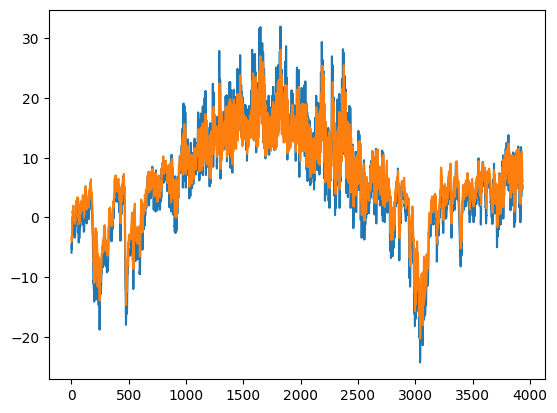

In [ ]:
plt.plot(range(1,len(y_test_inv)+1), y_test_inv)
plt.plot(range(1, len(y_pred_inv)+1), y_pred_inv)

## Регрессор (стек двух слое с LSTM)

In [ ]:
# Build the LSTM model
lstm_model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True),
    Dropout(0.2),
    tf.keras.layers.LSTM(10, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1. `lstm_model2 = tf.keras.Sequential(...)`:

  - Эта строка создает модель LSTM, используя API Sequential из Keras, популярной библиотеки для глубокого обучения.
  - API Sequential позволяет вам определить вашу модель как последовательность слоев, где выход одного слоя становится входом для следующего.

2. `tf.keras.layers.LSTM(10, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True)`:

  - Это первый слой модели LSTM, основной слой LSTM.
  - 10: Это указывает количество "единиц" или "ячеек памяти" внутри слоя LSTM. Эти единицы отвечают за изучение и запоминание закономерностей в данных.
  - `activation='relu'`: Функция активации relu (Rectified Linear Unit - выпрямленный линейный блок) вводит нелинейность в модель, что позволяет ей изучать более сложные закономерности в данных.
  - `input_shape=(X_train.shape[1], X_train.shape[2])`: Это определяет форму входных данных, которую ожидает слой LSTM. Она берется из размеров ваших обучающих данных (X_train). Форма ввода указывает, что модель получает один временной шаг за раз с определенным количеством признаков (определяется X_train.shape[2], который представляет исторические точки данных).
  - `return_sequences = True`: Этот аргумент важен при укладке слоев LSTM друг на друга. Устанавливая его в True, этот слой LSTM будет выводить последовательность скрытых состояний, а не только конечное скрытое состояние. Это необходимо для того, чтобы следующий слой LSTM мог обрабатывать последовательную информацию.

3. `Dropout(0.2)`:

  - Это метод регуляризации, используемый для предотвращения переобучения. Во время обучения он случайным образом "выбрасывает" (игнорирует) 20% нейронов в предыдущем слое. Это заставляет модель изучать более надежные признаки и лучше обобщать на невидимые данные.

4. `tf.keras.layers.LSTM(10, activation='relu')`:

  - Это второй слой LSTM, который получает на вход последовательность скрытых состояний от первого слоя LSTM.
  - Он имеет такое же количество единиц (10) и функцию активации (ReLU), как и первый слой.
  - Поскольку `return_sequences` был установлен в True в первом слое LSTM, этот второй слой LSTM может обрабатывать последовательную информацию, передаваемую ему.

5. `Dropout(0.2)`:

- Еще один слой dropout применяется после второго слоя LSTM, опять же для предотвращения переобучения.

6. `tf.keras.layers.Dense(1, activation='linear')`:

  - Это полносвязный (Dense) слой, который производит окончательный вывод модели.
  - 1: Он имеет один нейрон, который соответствует одному значению, которое предсказывает модель (например, температура на следующем временном шаге).
  - `activation='linear'`: Используется линейная функция активации, что означает, что выход представляет собой простую линейную комбинацию входных данных из предыдущего слоя. Это характерно для задач регрессии (предсказания непрерывных значений).

In [ ]:
# Compile the LSTM model

lstm_model2.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mae'])

1. `lstm_model2.compile(...)`: Эта строка инициирует процесс компиляции для lstm_model2, которая была определена ранее в коде. Компиляция - это как дать модели инструкции о том, как учиться.

2. `loss='mse'`:

  - `loss` - это важный аргумент, который определяет функцию потерь. Эта функция вычисляет разницу между предсказаниями модели и фактическими целевыми значениями.
  - `'mse'` означает Среднеквадратичную ошибку (Mean Squared Error), распространенную функцию потерь для задач регрессии. Она вычисляет среднее квадратов разностей между предсказанными и фактическими значениями. Цель модели во время обучения — минимизировать эту потерю.

3. `optimizer='adam'`:

  - `optimizer` определяет алгоритм оптимизации, используемый для обновления внутренних весов модели во время обучения. Эти веса — это то, что модель изучает, чтобы делать более точные предсказания.
  - `'adam'` относится к оптимизатору Adam, популярному и эффективному алгоритму для обучения нейронных сетей. Он адаптивно корректирует скорость обучения для каждого параметра, что приводит к более быстрой и стабильной сходимости.

4. `metrics=['mae']`:

  - `metrics` указывает метрики оценки, используемые для мониторинга производительности модели во время обучения и тестирования. В то время как функция потерь направляет процесс оптимизации, метрики обеспечивают более понятную для человека оценку точности модели.
  - `'mae'` означает Среднюю абсолютную ошибку (Mean Absolute Error), еще одну распространенную метрику для регрессии. Она вычисляет среднее абсолютных разностей между предсказанными и фактическими значениями. Это дает представление о средней ошибке прогнозирования в тех же единицах, что и целевая переменная.

In [ ]:
# Train the LSTM model

lstm_history2 = lstm_model2.fit(
    X_train, y_train,
    epochs=20,
    batch_size=20,
    validation_data=(X_val, y_val)
)

Epoch 1/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1008 - mae: 0.2452 - val_loss: 0.0078 - val_mae: 0.0688
Epoch 2/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0134 - mae: 0.0892 - val_loss: 0.0066 - val_mae: 0.0647
Epoch 3/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0087 - mae: 0.0709 - val_loss: 0.0047 - val_mae: 0.0522
Epoch 4/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0066 - mae: 0.0610 - val_loss: 0.0057 - val_mae: 0.0582
Epoch 5/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0061 - mae: 0.0578 - val_loss: 0.0052 - val_mae: 0.0550
Epoch 6/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0056 - mae: 0.0549 - val_loss: 0.0047 - val_mae: 0.0516
Epoch 7/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0054 - mae: 0.0535 - val_loss: 0.0046 - val_mae: 0.0511
Epoch 8/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0053 - mae: 0.0527 - val_loss: 0.0053 - val_mae: 0.0564
Epoch 9/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lo

### MSE, MAE & R2

In [ ]:
# Get R2, MSE & MAE scores
y_pred = lstm_model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R-squared (R^2): {r2:.2f}')

123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
MSE: 0.01
MAE: 0.06
R-squared (R^2): 0.67


1. `y_pred = lstm_model2.predict(X_test)`:

  - Эта строка использует обученную LSTM-модель (`lstm_model2`) для создания прогнозов на тестовых данных (`X_test`).
  - Прогнозы сохраняются в переменной y_pred.

2. `mse = mean_squared_error(y_test, y_pred)`:

  - Эта строка вычисляет среднеквадратичную ошибку (MSE) между фактическими значениями (`y_test`) и прогнозируемыми значениями (`y_pred`).
  - MSE измеряет среднее квадратичное различие между прогнозируемыми и фактическими значениями. Более низкие значения MSE указывают на лучшую производительность модели.

3. `mae = mean_absolute_error(y_test, y_pred)`:

  - Эта строка вычисляет среднюю абсолютную ошибку (MAE) между фактическими значениями (`y_test`) и прогнозируемыми значениями (`y_pred`).
  - MAE измеряет среднее абсолютное различие между прогнозируемыми и фактическими значениями. Ее легче интерпретировать, чем MSE, поскольку она выражается в тех же единицах, что и целевая переменная. Более низкие значения MAE указывают на лучшую производительность модели.

4. `r2 = r2_score(y_test, y_pred)`:

  - Эта строка вычисляет коэффициент детерминации (R^2) между фактическими значениями (`y_test`) и прогнозируемыми значениями (`y_pred`).
  - R^2 - это статистическая мера, которая представляет долю дисперсии целевой переменной, которая объясняется моделью. Он варьируется от 0 до 1, где более высокие значения указывают на лучшую подгонку модели к данным.

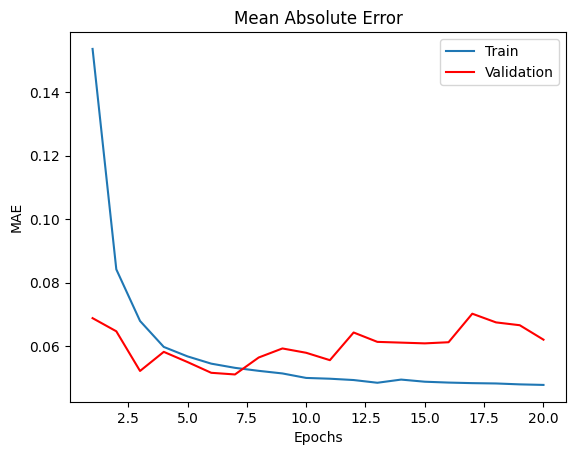

In [ ]:
# Visualize the mean absolute error (MAE)
mae = lstm_history2.history['mae']
val_mae = lstm_history2.history['val_mae']
epochs = range(1, len(mae)+1)

plt.title('Mean Absolute Error')
plt.plot(epochs, mae, label='Train')
plt.plot(epochs, val_mae, color='red', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

### Predicting

In [ ]:
# Predict using test sets

y_pred = lstm_model2.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE =  3.797  degrees
R2-score =  0.666


1. `y_pred = lstm_model2.predict(X_test)`: Эта строка использует обученную модель LSTM (`lstm_model2`) для создания прогнозов на тестовом наборе данных (`X_test`). Прогнозы сохраняются в переменной `y_pred`. Эти прогнозы, находятся в масштабированном формате (например, между 0 и 1), если модель была обучена на масштабированных данных.

2. `y_pred_inv = min_max_scaler.inverse_transform(y_pred)`: Эта строка отменяет масштабирование, примененное к прогнозам (`y_pred`), чтобы вернуть их к исходным единицам измерения (например, градусам Цельсия). Она использует объект `min_max_scaler` (который, использовался ранее для масштабирования данных) для выполнения обратного преобразования. Результаты, прогнозы в исходном масштабе, сохраняются в `y_pred_inv`.

3. `y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))`: Аналогично предыдущей строке, эта строка отменяет масштабирование, примененное к фактическим целевым значениям (`y_test`). Перед применением обратного преобразования `y_test` изменяется с помощью `reshape(-1, 1)`. Это делается для того, чтобы убедиться, что он имеет правильную форму, ожидаемую функцией `inverse_transform` (двумерный массив с одним столбцом). Результаты, фактические целевые значения в исходном масштабе, сохраняются в `y_test_inv`.

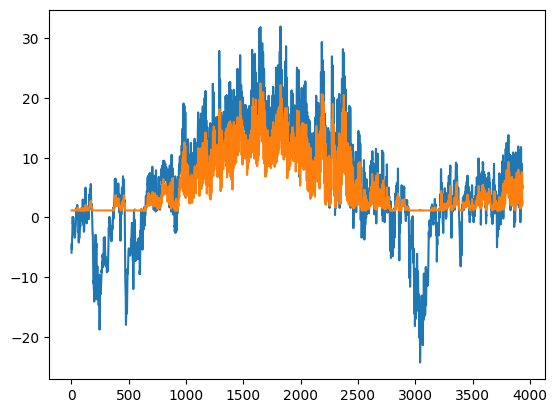

In [ ]:
# Visualize prediction

plt.plot(range(1, len(y_test_inv)+1), y_test_inv)
plt.plot(range(1, len(y_pred_inv)+1), y_pred_inv)

##Вывод

Этот код реализует две модели LSTM для прогнозирования временных рядов, в частности, для прогнозирования температуры. Первая модель использует обратные вызовы EarlyStopping и ModelCheckpoint для оптимизации обучения, предотвращения переобучения и сохранения весов модели с наилучшей производительностью. Обе модели оцениваются с использованием метрик MSE, MAE и R-квадрат, а их производительность визуализируется. Вторая модель представляет собой сложенную архитектуру LSTM с двумя слоями LSTM и регуляризацией dropout для улучшения обобщения. Код также включает этапы предварительной обработки данных, такие как масштабирование MinMax, и этапы постобработки для обратного преобразования прогнозов для правильной интерпретации. Финальные визуализации сравнивают прогнозируемые и фактические температуры, обеспечивая наглядную оценку производительности модели. Результаты указывают на эффективность архитектуры LSTM для задачи прогнозирования температуры. Сложная модель LSTM (lstm_model2) демонстрирует потенциал, но дальнейшая настройка гиперпараметров и, возможно, большее количество данных могут еще больше повысить ее точность.